# RGB crack detection tests - Fourier transforms

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from skimage.io import imread, imshow
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage import color, exposure, transform
from skimage.exposure import equalize_hist, equalize_adapthist

Another way of characterizing cracks (and, hopefully, holes) in images are Fourier transforms. This is a mathematical tool that decomposes a signal (both 1-D as audio, 2-D as images, or N-D as hypercubic tesseractian future television shows) into sine and cosine components of different frequencies at different weights.

This can be useful for characterizing pole images, as I hypothesize that poles with cracks will be reflected as Fourier transform images with high frequencies, whereas good poles are relatively uniform and won't have excessively high frequencies.

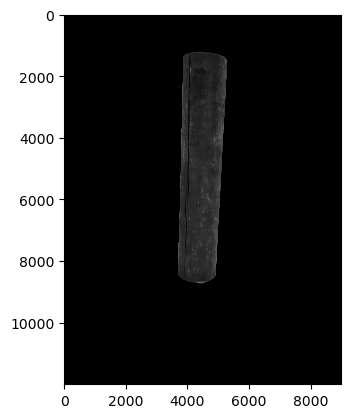

In [9]:
pole = cv2.imread('../Data/RGB/crops/Ny_0_crop_masked.jpg')
pole = cv2.cvtColor(pole, cv2.COLOR_RGB2GRAY)
plt.imshow(pole, cmap='gray')

As an example, applying the Fourier transform to an image is quite straightforward, as this cell shows:

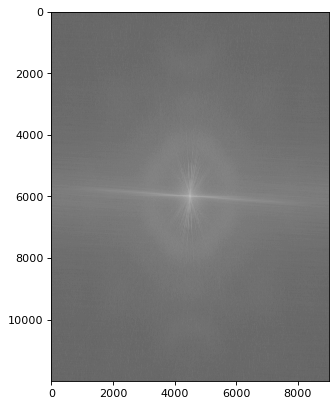

In [10]:
dark_image_grey_fourier = np.fft.fftshift(np.fft.fft2(pole))
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(np.log(abs(dark_image_grey_fourier)), cmap='gray')

This image is the result of applying the FFT algorithm to the previous pole image. The big horizontal line in the middle represents the predominant vertical spatial frequencies in the pole, which makes sense, because the pole image is essentially... vertical.

Therefore, it is interesting to see the results of the FFT algorithm for other images.

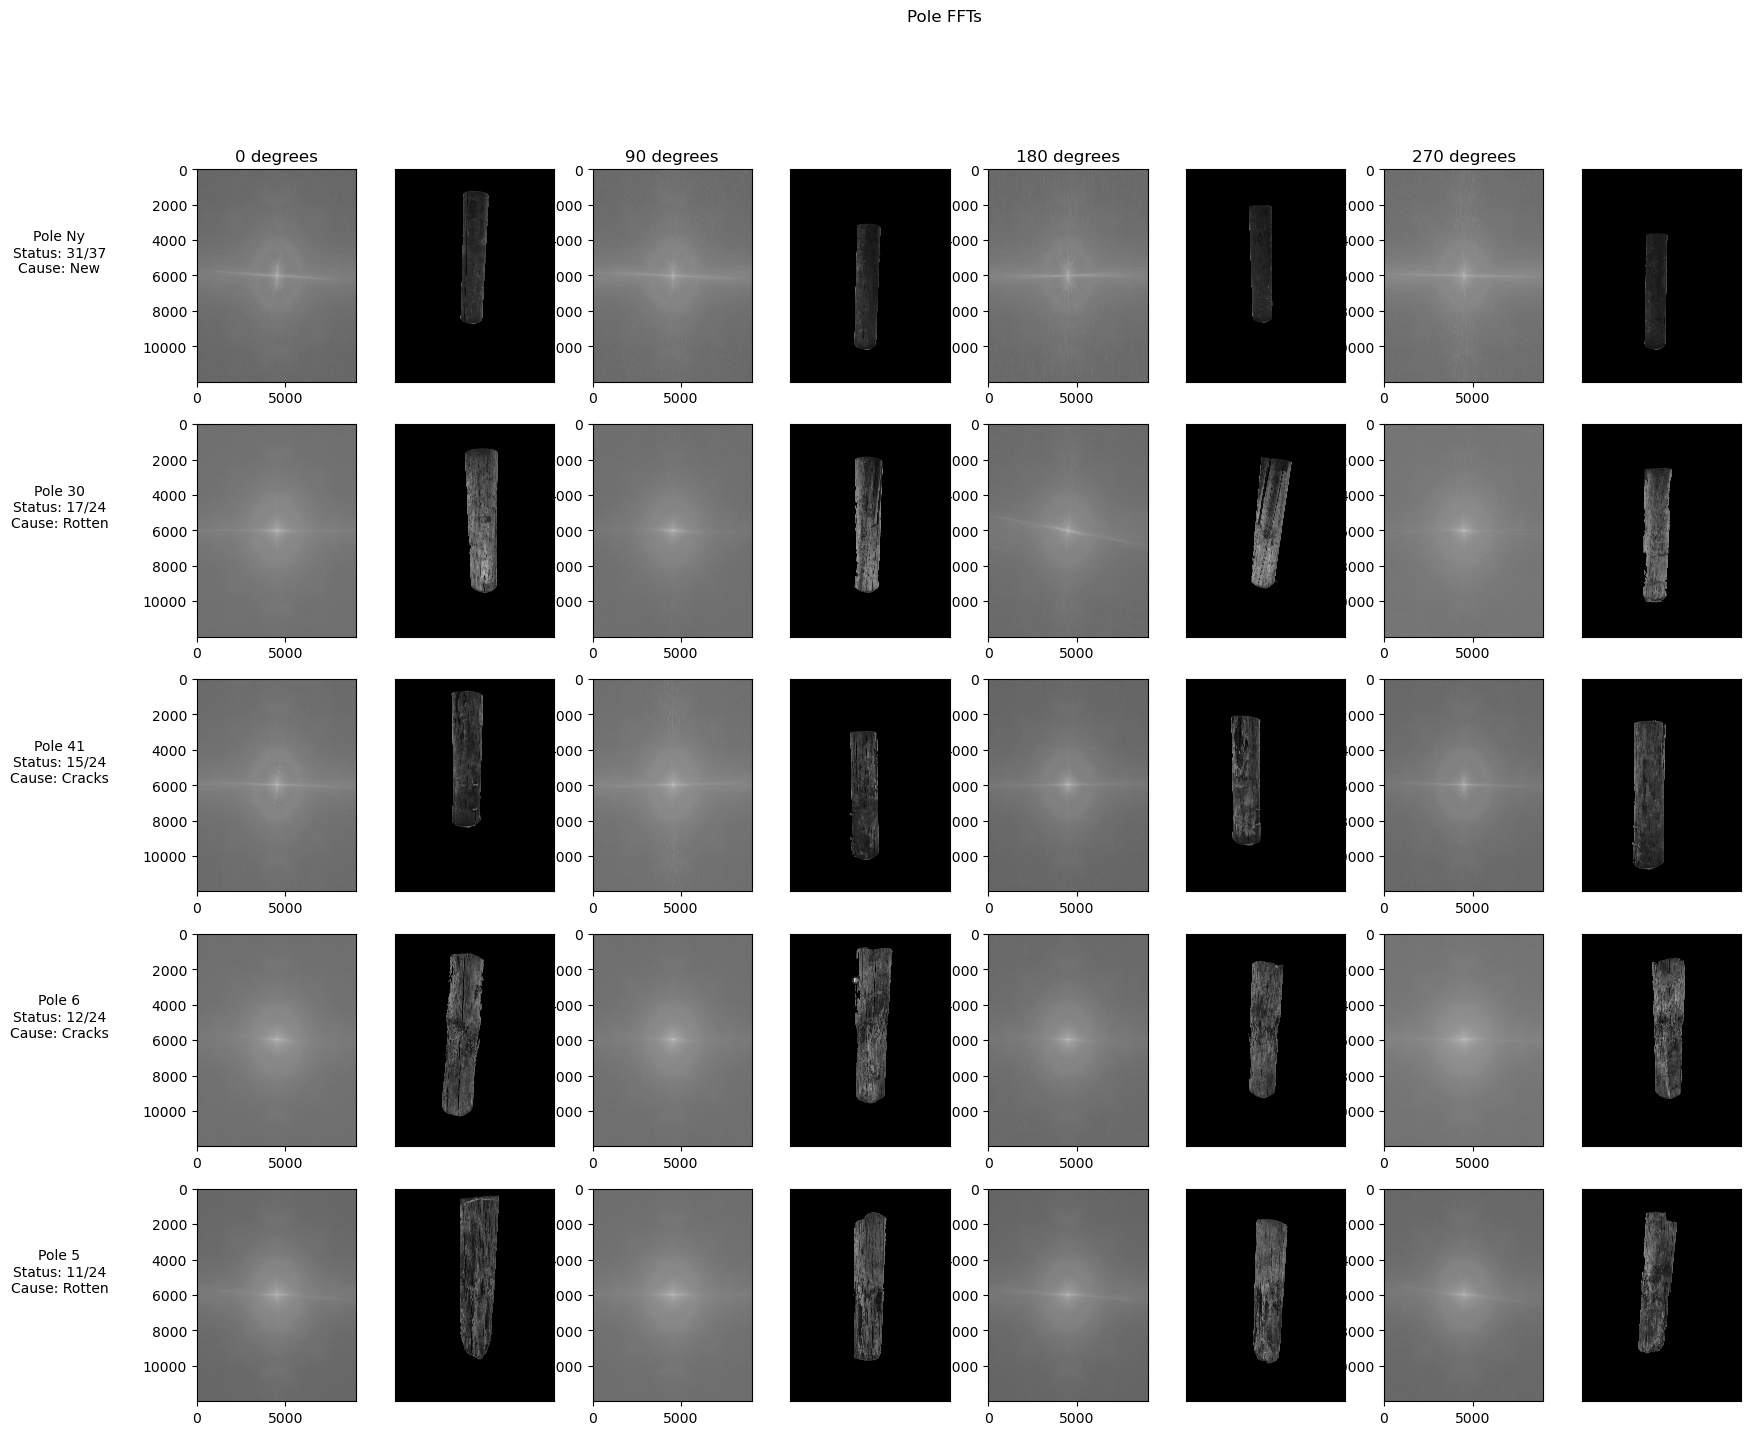

In [13]:
def visualize_ffts():
    fig, axes = plt.subplots(5, 8, figsize=(20,16))
    pole_ids = ['Ny',30,41,6,5]
    pole_status = ['31/37', '17/24', '15/24', '12/24', '11/24']
    specific_status = ['New', 'Rotten', 'Cracks', 'Cracks', 'Rotten']

    for pole_idx, pole_id in enumerate(pole_ids):
        for rotation_idx, rotation in enumerate([0, 90, 180, 270]):
            img = cv2.imread(f'../Data/RGB/crops/{pole_id}_{rotation}_crop_masked.jpg')
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            fft = np.fft.fftshift(np.fft.fft2(img))
            axes[pole_idx, rotation_idx*2].imshow(np.log(abs(fft)), cmap='gray')
            axes[pole_idx, rotation_idx*2+1].imshow(img, cmap='gray')
            axes[pole_idx, rotation_idx*2+1].set_xticks([])
            axes[pole_idx, rotation_idx*2+1].set_yticks([])

    fig.suptitle('Pole FFTs')

    [axes[0,i*2].set_title(f'{i*90} degrees') for i in range(4)]

    [axes[i,0].set_ylabel(f'Pole {pole}\nStatus: {pole_status[i]}\nCause: {specific_status[i]}', labelpad=60, fontdict={'rotation':0}) for i, pole in enumerate(pole_ids)]

    plt.savefig('../Figures/pole_ffts.jpg')
    
visualize_ffts()

Unfortunately, it seems like not much information can be extracted from the Fourier transforms. However, since cracks are a vertical component, it would be interesting to see the images resulting from applying the inverse Fourier transform when removing the middle bands (corresponding to vertical lines).

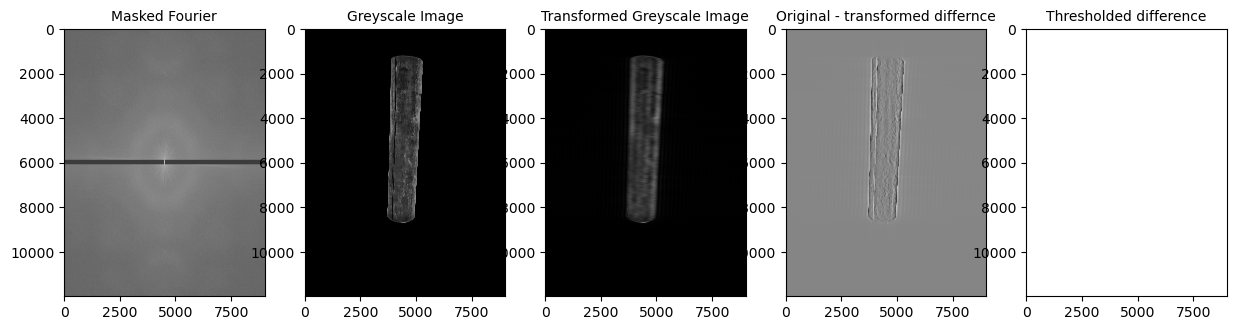

In [56]:
img = cv2.imread('../Data/RGB/crops/Ny_0_crop_masked.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img = equalize_adapthist(img)

def fourier_masker(image, i):
    f_size = 10
    dark_image_grey_fourier = np.fft.fftshift(np.fft.fft2(image))    
    dark_image_grey_fourier[5900:6100, :4475] = i
    dark_image_grey_fourier[5900:6100, -4475:] = i
    inverse = abs(np.fft.ifft2(dark_image_grey_fourier))
    diff_img = -(image - inverse)
    thresholded = np.where(diff_img > -50, 1, 0)
    fig, ax = plt.subplots(1,5,figsize=(15,15))
    ax[0].imshow(np.log(abs(dark_image_grey_fourier)), cmap='gray')
    ax[0].set_title('Masked Fourier', fontsize = f_size)
    ax[1].imshow(image, cmap = 'gray')
    ax[1].set_title('Greyscale Image', fontsize = f_size);
    ax[2].imshow(inverse, cmap='gray')
    ax[2].set_title('Transformed Greyscale Image', fontsize = f_size)
    ax[3].imshow(diff_img, cmap='gray')
    ax[3].set_title('Original - transformed differnce', fontsize = f_size)
    ax[4].imshow(thresholded, cmap='gray', vmin=0, vmax=1)
    ax[4].set_title('Thresholded difference', fontsize = f_size)
    return diff_img
    
diff = fourier_masker(img, 1)

As seen above and below, it looks like it **might** be possible to only so slightly capture cracks by removing some vertical frequencies from the images, but to fully assess this, I should plot all pole images 

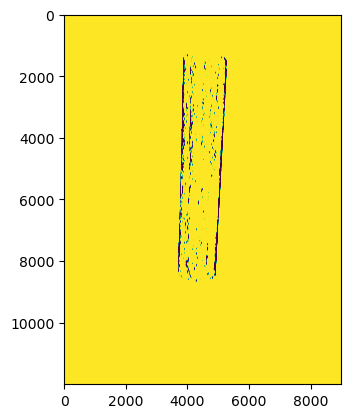

In [53]:
plt.imshow(np.where(diff > -50, 1, 0))

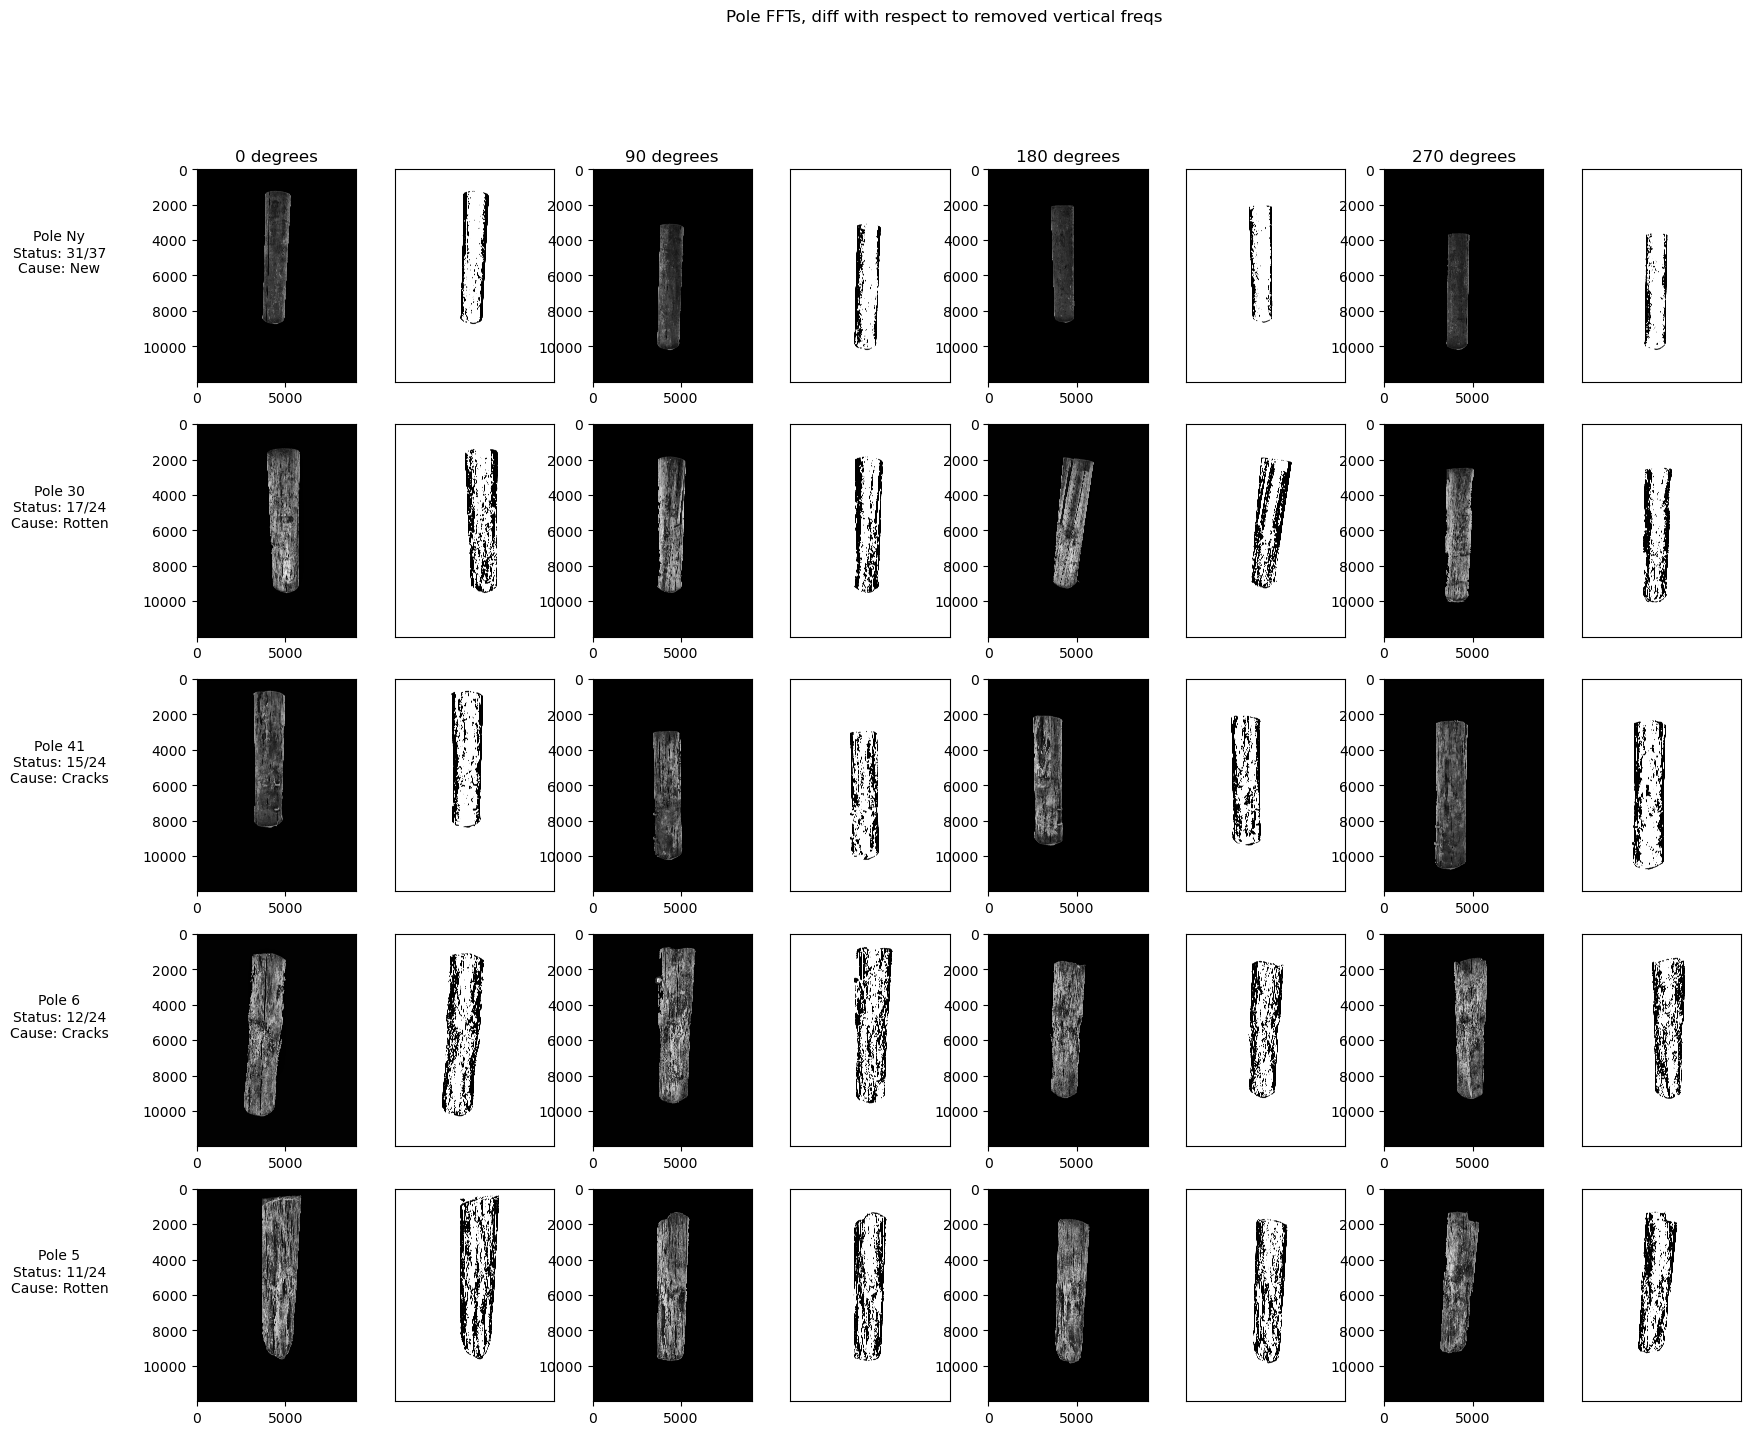

In [3]:
def visualize_ffts_diffs():
    fig, axes = plt.subplots(5, 8, figsize=(20,16))
    pole_ids = ['Ny',30,41,6,5]
    pole_status = ['31/37', '17/24', '15/24', '12/24', '11/24']
    specific_status = ['New', 'Rotten', 'Cracks', 'Cracks', 'Rotten']

    for pole_idx, pole_id in enumerate(pole_ids):
        for rotation_idx, rotation in enumerate([0, 90, 180, 270]):
            img = cv2.imread(f'../Data/RGB/crops/{pole_id}_{rotation}_crop_masked.jpg')
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = equalize_adapthist(img)
            dark_image_grey_fourier = np.fft.fftshift(np.fft.fft2(img))    
            dark_image_grey_fourier[5900:6100, :4495] = 1
            dark_image_grey_fourier[5900:6100, -4495:] = 1
            inverse = abs(np.fft.ifft2(dark_image_grey_fourier))
            diff_img = -(img - inverse)
            thresholded = np.where(diff_img > -0.06, 1, 0)
            axes[pole_idx, rotation_idx*2].imshow(img, cmap='gray')
            axes[pole_idx, rotation_idx*2+1].imshow(thresholded, cmap='gray')
            axes[pole_idx, rotation_idx*2+1].set_xticks([])
            axes[pole_idx, rotation_idx*2+1].set_yticks([])

    fig.suptitle('Pole FFTs, diff with respect to removed vertical freqs')

    [axes[0,i*2].set_title(f'{i*90} degrees') for i in range(4)]

    [axes[i,0].set_ylabel(f'Pole {pole}\nStatus: {pole_status[i]}\nCause: {specific_status[i]}', labelpad=60, fontdict={'rotation':0}) for i, pole in enumerate(pole_ids)]

    plt.savefig('../Figures/pole_ffts_diffs.jpg')
    
visualize_ffts_diffs()

As it can be seen in these images, removing most high frequencies from images and computing the difference of the result w.r.t. the original image doesn't give a very clear view of the pole's surface spatial characteristics. Furthermore, FFT is extremely slow for these images. Thus, I won't invest much more time into this idea.